In [1]:
import xarray as xr
import pop_tools
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import cartopy
import cmocean as cmo
import glob
import os

ccrs = cartopy.crs

In [7]:
taux_file = '/Data/gfi/share/ModData/CESM2_LENS2/ocean/monthly/taux/taux_1001.001.nc'
tauy_file = '/Data/gfi/share/ModData/CESM2_LENS2/ocean/monthly/tauy/tauy_1001.001.nc'

In [8]:
grid_name = 'POP_gx1v7'
region_defs = {
    'North Atlantic and Nordic Seas': [{'match': {'REGION_MASK': [6, 7, 9]}, 
                             'bounds': {'TLAT': [20., 78.]}}],
    'LabradorSea': [{'match': {'REGION_MASK': [8]}, 'bounds': {'TLAT': [45.0, 66.0]}}]
} 
mask3d = pop_tools.region_mask_3d(grid_name, region_defs=region_defs, mask_name='North Atlantic and Nordic Seas')
mask3d = mask3d.sum('region')

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [9]:
ds_taux = xr.open_dataset(taux_file).isel(time=slice(0,12)
                                         ).mean(dim='time').where(mask3d == 1).roll(nlon=+100)
ds_tauy = xr.open_dataset(tauy_file).isel(time=slice(0,12)
                                         ).mean(dim='time').where(mask3d == 1).roll(nlon=+100)

# Plot Magnitudes

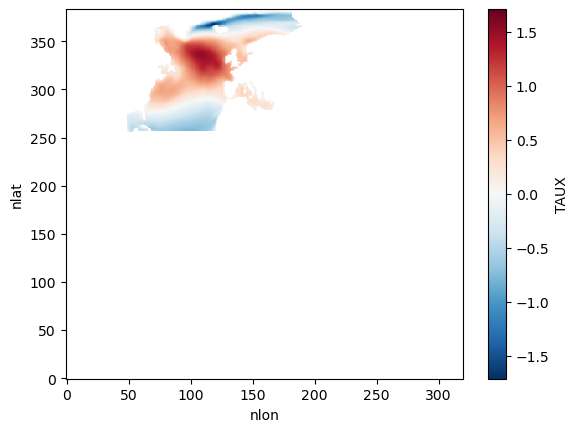

In [10]:
ds_taux.TAUX.plot()

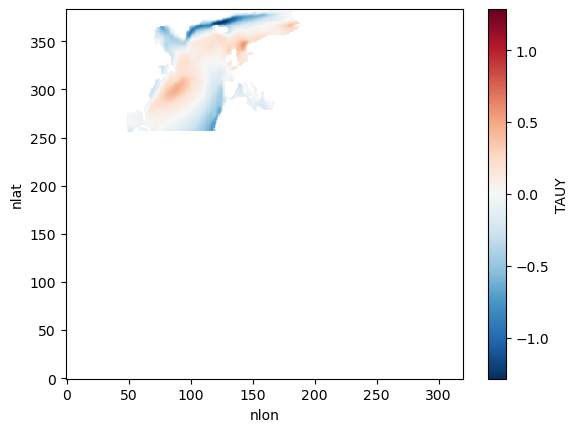

In [11]:
ds_tauy.TAUY.plot()

# Make quiver plot

(250.0, 385.0)

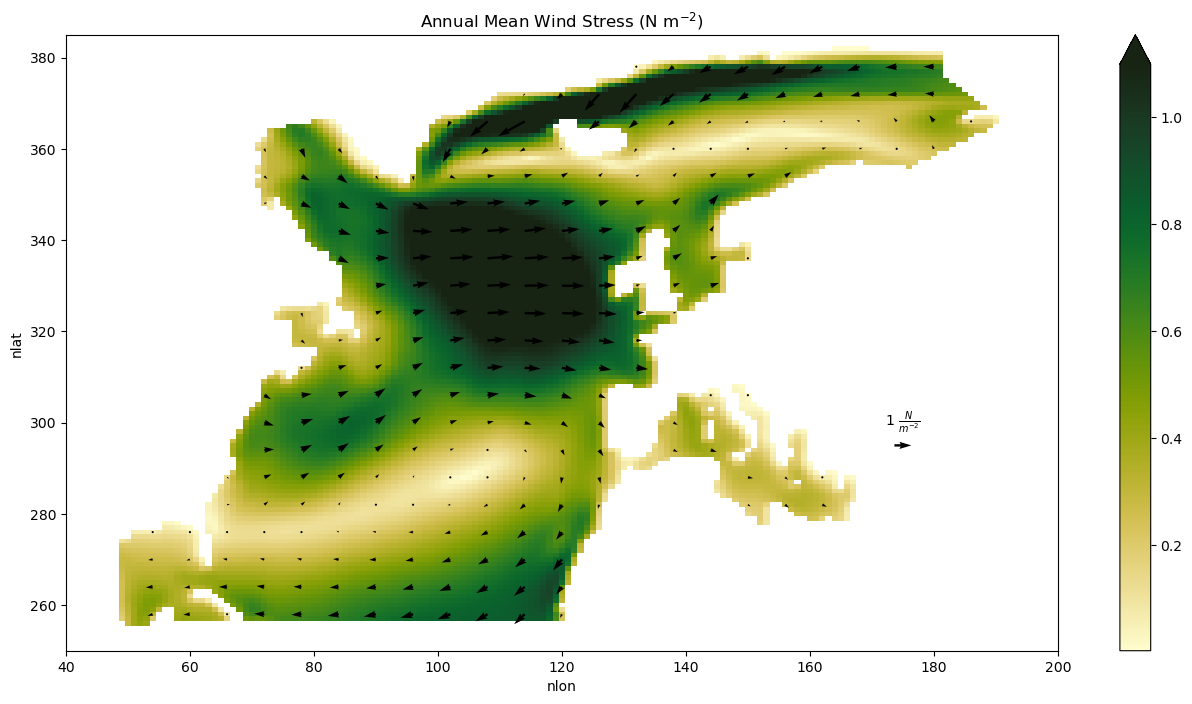

In [12]:
x = ds_taux.TAUX.nlon
y = ds_tauy.TAUY.nlat
mag = (ds_taux.TAUX**2 + ds_tauy.TAUY**2)**0.5
sampling_x=6
sampling_y=6
slx = slice(None, None, sampling_x)
sly = slice(None, None, sampling_y)
sl2d = (sly, slx)

fig, ax = plt.subplots(figsize=(16,8))
mag_max=1.1
mag.plot(ax=ax, vmax=mag_max, cmap=cmo.cm.speed)
q = ax.quiver(x[slx], y[sly], ds_taux.TAUX[sl2d], ds_tauy.TAUY[sl2d], color="k")

plt.quiverkey(q, 175, 295, 1, r"1 $\frac{N}{m^{-2}}$", coordinates="data")
plt.title(r'Annual Mean Wind Stress (N m$^{-2}$)')
plt.xlim(40, 200)
plt.ylim(250, 385)

# Make composites

In [61]:
### INITIALISATION

path = '/home/innag3580/phase1_CONDA/'

# Load data events and their temporal location
data = np.genfromtxt(path+'current/events_dens_spg.csv', delimiter=',', names=True, dtype=None)

# Accessing columns by name
member_numbers = data['Index']
events = data['Values']
member_names = np.zeros(len(member_numbers))

# set periods
before = 40*12
after = 20*12

# find file names 
def find_corresponding_file_name(vvel_number_to_find):
    with open(path+'timeseries/order.txt', 'r') as file:
        vvel_list = file.readlines()
    vvel_dict = {filename.split()[1]: int(filename.split()[0]) for filename in vvel_list}
    vvel_filename = None
    for filename in vvel_list:
        if vvel_dict[filename.split()[1]] == vvel_number_to_find:
            vvel_filename = filename.split()[1]  
            break
    return vvel_filename

In [63]:

### COMPUTATION

for i in range(0, len(member_numbers)):

    # define entire time range for event
    member = find_corresponding_file_name(member_numbers[i])[5:]
    event = events[i]*12
    period_start = event-before
    period_end = event+after
    
    print('computation member '+member+' started')

    # select time range in data arrays
    time = slice(period_start, period_end)

    # open files and take annual and March means 

    # taux annual
    taux_file = '/Data/gfi/share/ModData/CESM2_LENS2/ocean/monthly/taux/taux_'+member
    ds = xr.open_dataset(taux_file).isel(time=time).resample(time='A').mean(dim='time')
    if 'time_bound' in ds.variables:
        ds = ds.drop_vars('time_bound')
    ds.to_netcdf('/Data/gfi/share/ModData/CESM2_LENS2/ocean/monthly/comp/taux_annual_composite_'+member)
    ds.close()
    
    # tauy annual
    tauy_file = '/Data/gfi/share/ModData/CESM2_LENS2/ocean/monthly/tauy/tauy_'+member
    ds = xr.open_dataset(tauy_file).isel(time=time).resample(time='A').mean(dim='time')
    if 'time_bound' in ds.variables:
        ds = ds.drop_vars('time_bound')
    ds.to_netcdf('/Data/gfi/share/ModData/CESM2_LENS2/ocean/monthly/comp/tauy_annual_composite_'+member)
    ds.close()
    
    # taux March
    taux_file = '/Data/gfi/share/ModData/CESM2_LENS2/ocean/monthly/taux/taux_'+member
    ds = xr.open_dataset(taux_file).isel(time=time)
    ds = ds.isel(time=(ds['time.month'] == 3))
    if 'time_bound' in ds.variables:
        ds = ds.drop_vars('time_bound')
    ds.to_netcdf('/Data/gfi/share/ModData/CESM2_LENS2/ocean/monthly/comp/taux_march_composite_'+member)
    ds.close()

    # taux March
    tauy_file = '/Data/gfi/share/ModData/CESM2_LENS2/ocean/monthly/tauy/tauy_'+member
    ds = xr.open_dataset(tauy_file).isel(time=time)
    ds = ds.isel(time=(ds['time.month'] == 3))
    if 'time_bound' in ds.variables:
        ds = ds.drop_vars('time_bound')
    ds.to_netcdf('/Data/gfi/share/ModData/CESM2_LENS2/ocean/monthly/comp/tauy_march_composite_'+member)
    ds.close()
    
    print(member+' saved')

print('process complete')

computation member 1301.019.nc started
1301.019.nc saved
computation member 1231.001.nc started
1231.001.nc saved
computation member 1281.012.nc started
1281.012.nc saved
computation member 1301.001.nc started
1301.001.nc saved
computation member 1281.017.nc started
1281.017.nc saved
computation member 1231.020.nc started
1231.020.nc saved
computation member 1231.004.nc started
1231.004.nc saved
computation member 1281.010.nc started
1281.010.nc saved
computation member 1281.020.nc started
1281.020.nc saved
computation member 1301.015.nc started
1301.015.nc saved
computation member 1281.015.nc started
1281.015.nc saved
computation member 1231.003.nc started
1231.003.nc saved
computation member 1251.010.nc started
1251.010.nc saved


# COMPUTE 60 YEAR ANNUAL COMPOSITES

In [78]:
taux_files_annual = sorted(glob.glob('/Data/gfi/share/ModData/CESM2_LENS2/ocean/monthly/comp/taux_annual_composite_*.nc'))
tauy_files_annual = sorted(glob.glob('/Data/gfi/share/ModData/CESM2_LENS2/ocean/monthly/comp/tauy_annual_composite_*.nc'))
taux_files_march = sorted(glob.glob('/Data/gfi/share/ModData/CESM2_LENS2/ocean/monthly/comp/taux_march_composite_*.nc'))
tauy_files_march = sorted(glob.glob('/Data/gfi/share/ModData/CESM2_LENS2/ocean/monthly/comp/tauy_march_composite_*.nc'))

In [79]:
# annual files
var_years_taux_annual = []
var_years_tauy_annual = []

for t in range(60):
    var_year_x_annual = []
    var_year_y_annual = []
    
    for i in range(len(taux_files_annual)):
        try:
            ds_x = xr.open_dataset(taux_files_annual[i])
        except ValueError as e:
            continue
        
        ds_file_x = ds_x['TAUX'].isel(time=t)
        var_year_x_annual.append(ds_file_x)
        ds_x.close()
        
        try:
            ds_y = xr.open_dataset(tauy_files_annual[i])
        except ValueError as e:
            continue

        ds_file_y = ds_y['TAUY'].isel(time=t)
        var_year_y_annual.append(ds_file_y)
        ds_y.close()

    ds_comp_x_annual = xr.concat(var_year_x_annual, dim='file').mean(dim='file')
    ds_comp_y_annual = xr.concat(var_year_y_annual, dim='file').mean(dim='file')
    var_years_taux_annual.append(ds_comp_x_annual)
    var_years_tauy_annual.append(ds_comp_y_annual)

ds_var_annual_x = xr.concat(var_years_taux_annual, dim='time')
ds_var_annual_x.to_netcdf('/Data/gfi/share/ModData/CESM2_LENS2/ocean/monthly/comp/TAUXcomposite_annual.nc')

ds_var_annual_y = xr.concat(var_years_tauy_annual, dim='time')
ds_var_annual_y.to_netcdf('/Data/gfi/share/ModData/CESM2_LENS2/ocean/monthly/comp/TAUYcomposite_annual.nc')

# March files
var_years_taux_march = []
var_years_tauy_march = []

for t in range(60):
    var_year_x_march = []
    var_year_y_march = []
    
    for i in range(len(taux_files_march)):
        try:
            ds_x = xr.open_dataset(taux_files_march[i])
        except ValueError as e:
            continue

        ds_file_x = ds_x['TAUX'].isel(time=t)
        var_year_x_march.append(ds_file_x)
        ds_x.close()
        
        try:
            ds_y = xr.open_dataset(tauy_files_march[i])
        except ValueError as e:
            continue

        ds_file_y = ds_y['TAUY'].isel(time=t)
        var_year_y_march.append(ds_file_y)
        ds_y.close()

    ds_comp_x_march = xr.concat(var_year_x_march, dim='file').mean(dim='file')
    ds_comp_y_march = xr.concat(var_year_y_march, dim='file').mean(dim='file')
    var_years_taux_march.append(ds_comp_x_march)
    var_years_tauy_march.append(ds_comp_y_march)

ds_var_march_x = xr.concat(var_years_taux_march, dim='time')
ds_var_march_x.to_netcdf('/Data/gfi/share/ModData/CESM2_LENS2/ocean/monthly/comp/TAUXcomposite_march.nc')

ds_var_march_y = xr.concat(var_years_tauy_march, dim='time')
ds_var_march_y.to_netcdf('/Data/gfi/share/ModData/CESM2_LENS2/ocean/monthly/comp/TAUYcomposite_march.nc')

print('Process complete')


Process complete


# Plot anomaly

In [24]:
taux_file = os.path.expanduser('/Data/gfi/share/ModData/CESM2_LENS2/ocean/monthly/comp/TAUXcomposite_march.nc')
ds_taux = xr.open_dataset(taux_file).roll(nlon=+100)
tauy_file = os.path.expanduser('/Data/gfi/share/ModData/CESM2_LENS2/ocean/monthly/comp/TAUYcomposite_march.nc')
ds_tauy = xr.open_dataset(tauy_file).roll(nlon=+100)

mag = (ds_taux.TAUX**2 + ds_tauy.TAUY**2)**0.5

period1_avg = mag.isel(time=slice(0,35)).mean(dim='time')  
period2_avg = mag.isel(time=slice(45,59)).mean(dim='time')
ds_mag_anom = period2_avg - period1_avg

period1_avg = ds_taux.isel(time=slice(0,35)).mean(dim='time')  
period2_avg = ds_taux.isel(time=slice(45,59)).mean(dim='time')
ds_taux_anom = period2_avg - period1_avg

period1_avg = ds_tauy.isel(time=slice(0,35)).mean(dim='time')  
period2_avg = ds_tauy.isel(time=slice(45,59)).mean(dim='time')
ds_tauy_anom = period2_avg - period1_avg

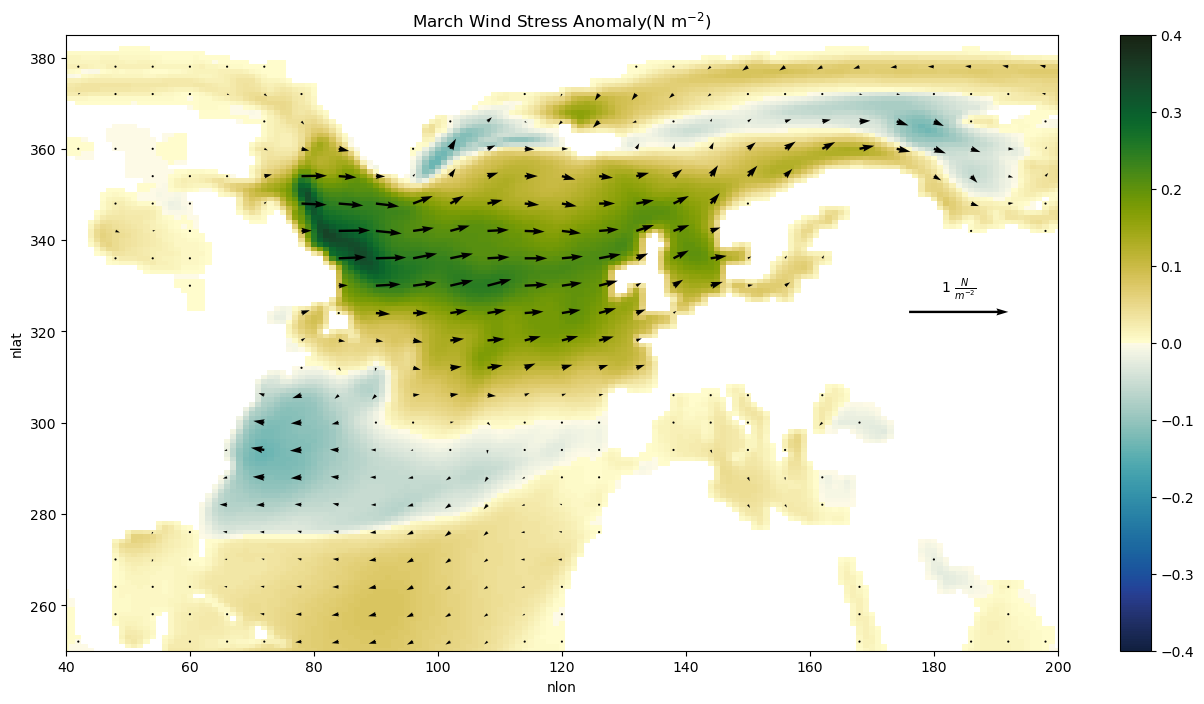

In [25]:
x = ds_taux.TAUX.nlon
y = ds_tauy.TAUY.nlat

sampling_x=6
sampling_y=6
slx = slice(None, None, sampling_x)
sly = slice(None, None, sampling_y)
sl2d = (sly, slx)

fig, ax = plt.subplots(figsize=(16,8))
mag_max=0.4
ds_mag_anom.plot(ax=ax, vmax=mag_max, cmap=cmo.cm.delta)

q = ax.quiver(x[slx], y[sly], ds_taux_anom.TAUX[sl2d], ds_tauy_anom.TAUY[sl2d], color="k", scale=10)

plt.quiverkey(q, 0.9, 0.55, 1, r"1 $\frac{N}{m^{-2}}$", coordinates="axes")

plt.title(r'March Wind Stress Anomaly(N m$^{-2}$)')
plt.xlim(40, 200)
plt.ylim(250, 385)
plt.show()

In [32]:
taux_file = os.path.expanduser('/Data/gfi/share/ModData/CESM2_LENS2/ocean/monthly/comp/TAUXcomposite_annual.nc')
ds_taux = xr.open_dataset(taux_file).roll(nlon=+100)

tauy_file = os.path.expanduser('/Data/gfi/share/ModData/CESM2_LENS2/ocean/monthly/comp/TAUYcomposite_annual.nc')
ds_tauy = xr.open_dataset(tauy_file).roll(nlon=+100)

mag = (ds_taux.TAUX**2 + ds_tauy.TAUY**2)**0.5

period1_avg = mag.isel(time=slice(0,35)).mean(dim='time')  
period2_avg = mag.isel(time=slice(45,59)).mean(dim='time')
ds_mag_anom = period2_avg - period1_avg

period1_avg = ds_taux.isel(time=slice(0,35)).mean(dim='time')  
period2_avg = ds_taux.isel(time=slice(45,59)).mean(dim='time')
ds_taux_anom = period2_avg - period1_avg

period1_avg = ds_tauy.isel(time=slice(0,35)).mean(dim='time')  
period2_avg = ds_tauy.isel(time=slice(45,59)).mean(dim='time')
ds_tauy_anom = period2_avg - period1_avg

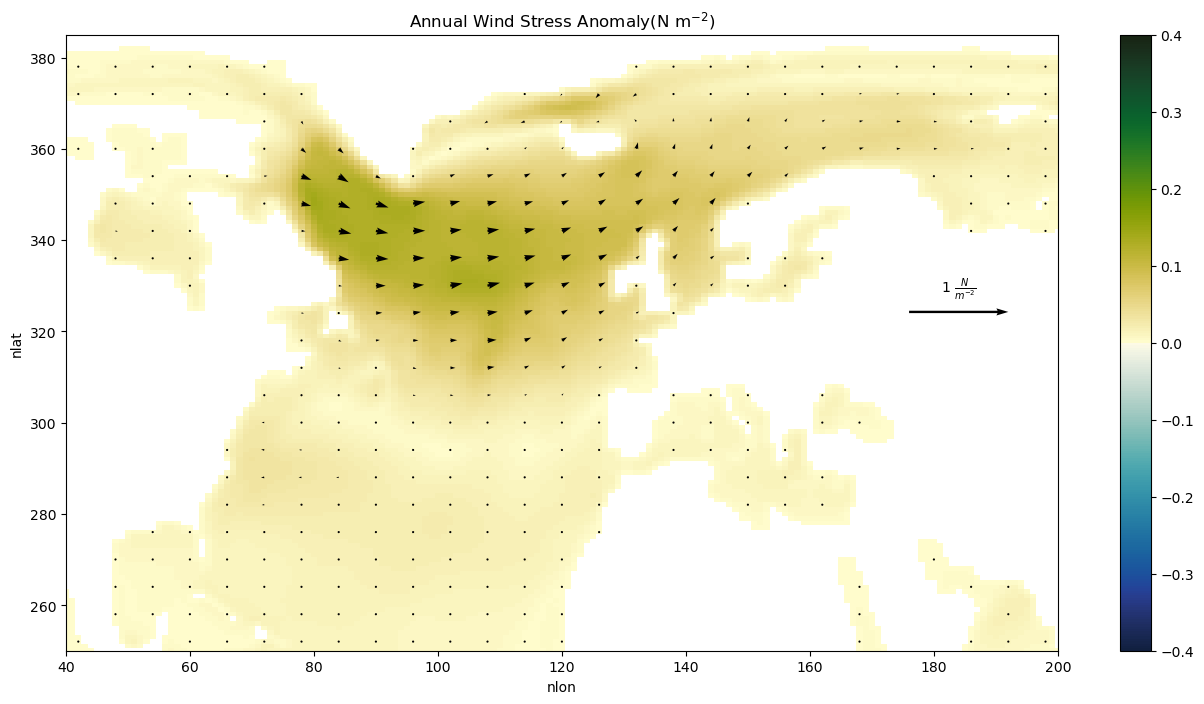

In [36]:
x = ds_taux.TAUX.nlon
y = ds_tauy.TAUY.nlat
mag = (ds_taux_anom.TAUX**2 + ds_tauy_anom.TAUY**2)**0.5
sampling_x=6
sampling_y=6
slx = slice(None, None, sampling_x)
sly = slice(None, None, sampling_y)
sl2d = (sly, slx)


fig, ax = plt.subplots(figsize=(16,8))
mag_max=0.4
mag.plot(ax=ax, vmax=mag_max, vmin=-mag_max, cmap=cmo.cm.delta)

q = ax.quiver(x[slx], y[sly], ds_taux_anom.TAUX[sl2d], ds_tauy_anom.TAUY[sl2d], color="k", scale=10)

plt.quiverkey(q, 0.9, 0.55, 1, r"1 $\frac{N}{m^{-2}}$", coordinates="axes")
plt.title(r'Annual Wind Stress Anomaly(N m$^{-2}$)')
plt.xlim(40, 200)
plt.ylim(250, 385)
plt.show()

# Plot March flip book

In [37]:
def replace_nonfinite_values(ds, variable_names, replacement_value=0):
    """
    Replace non-finite values and masked values in the specified variables of the dataset.

    Parameters:
    - ds (xarray.Dataset): The dataset containing the variables to be processed.
    - variable_names (list): A list of variable names to process.
    - replacement_value (float): The value to replace non-finite and masked values with.

    Returns:
    - ds_replaced (xarray.Dataset): The dataset with non-finite and masked values replaced.
    """

    ds_replaced = ds.copy()  # Create a copy of the original dataset

    for var_name in variable_names:
        # Replace non-finite values and masked values in the variable
        ds_replaced[var_name] = xr.where(
            np.logical_or(
                np.isnan(ds[var_name]),
                np.isinf(ds[var_name]) | np.ma.getmask(ds[var_name])
            ),
            replacement_value,
            ds[var_name]
        )

    return ds_replaced


In [45]:
taux_file = os.path.expanduser('/Data/gfi/share/ModData/CESM2_LENS2/ocean/monthly/comp/TAUXcomposite_march.nc')
ds_taux_annual = xr.open_dataset(taux_file)
ds_taux_annual = replace_nonfinite_values(ds_taux_annual, ['TLAT', 'TLONG'], replacement_value=0)

tauy_file = os.path.expanduser('/Data/gfi/share/ModData/CESM2_LENS2/ocean/monthly/comp/TAUYcomposite_march.nc')
ds_tauy_annual = xr.open_dataset(tauy_file)
ds_tauy_annual = replace_nonfinite_values(ds_tauy_annual, ['TLAT', 'TLONG'], replacement_value=0)

da_mag = (ds_taux_annual.TAUX**2 + ds_tauy_annual.TAUY**2)**0.5
da_anom_mag = da_mag - da_mag.isel(time=slice(0,40)).mean('time')

In [ ]:
vmax = 0.7
vmin = -vmax
x = ds_taux_annual.TAUX.nlon
y = ds_taux_annual.TAUX.nlat
sampling_x=6
sampling_y=6
slx = slice(None, None, sampling_x)
sly = slice(None, None, sampling_y)
sl2d = (sly, slx)

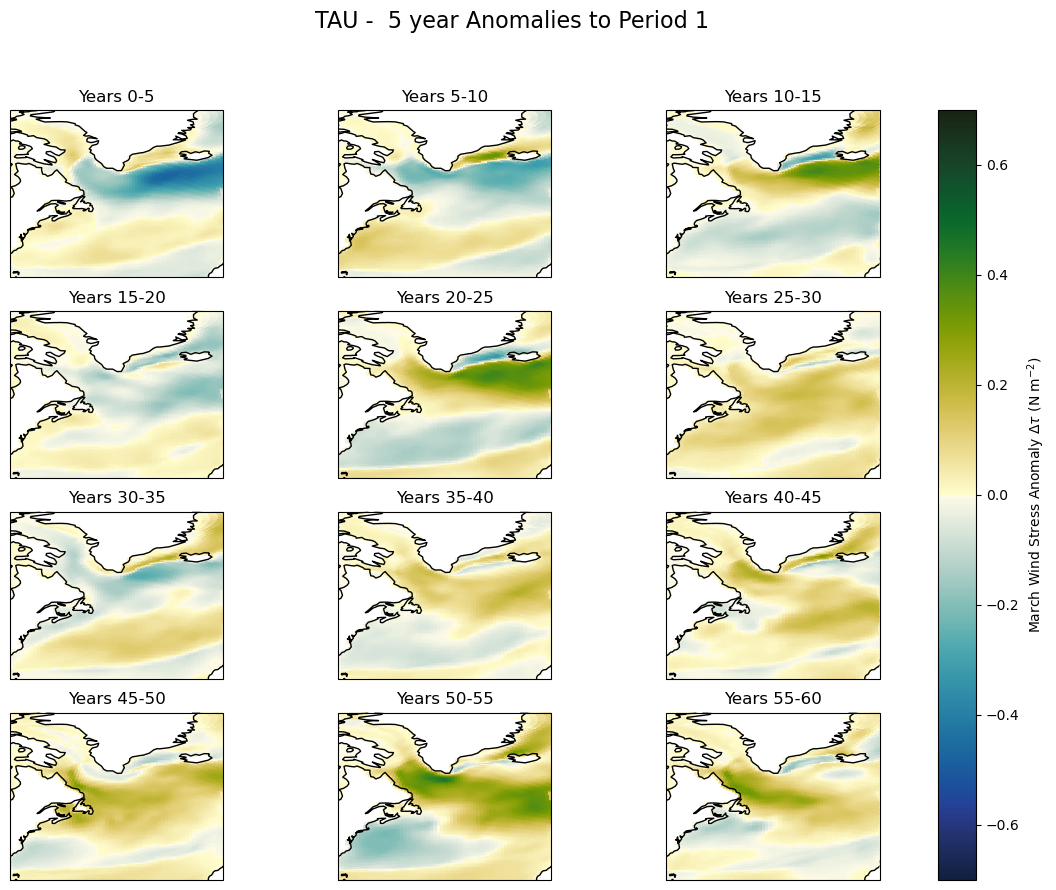

In [48]:
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(15, 10), subplot_kw={'projection': ccrs.PlateCarree()})
for i, ax in enumerate(axes.flatten()):
    pc = da_anom_mag.isel(time=range(i*5, i*5+5)).mean('time').plot.pcolormesh(
                                                 ax=ax,
                                                 transform=ccrs.PlateCarree(),
                                                 x='TLONG',
                                                 y='TLAT',
                                                 cmap=cmo.cm.delta,
                                                 vmin = vmin, vmax = vmax,
                                                 add_colorbar=False) 
    ax.set_extent([-80,-10, 25, 80], crs=ccrs.PlateCarree())
    ax.set_title(f"Years {(i*5)}-{(i*5)+5}")
    ax.coastlines()
    #cs = ax.contour(x, y, da_mag.isel(time=slice(0, 40)).mean('time'), linewidths=0.5, colors='gray',transform=ccrs.PlateCarree())
    #ax.clabel(cs, fmt='%1.0f', inline=True, fontsize=8)
cbar = fig.colorbar(pc, ax=axes, orientation='vertical', label=r'March Wind Stress Anomaly $\Delta \tau$ (N m$^{-2}$)') 
fig.suptitle('TAU -  5 year Anomalies to Period 1', fontsize=16)
plt.show()
#plt.savefig(os.path.expanduser('~/phase1_CONDA/results/')+TAU_5year_anomalies.png', bbox_inches='tight', dpi=300)    

# Plot Annual flip book

In [49]:
taux_file = os.path.expanduser('/Data/gfi/share/ModData/CESM2_LENS2/ocean/monthly/comp/TAUXcomposite_annual.nc')
ds_taux_annual = xr.open_dataset(taux_file)
ds_taux_annual = replace_nonfinite_values(ds_taux_annual, ['TLAT', 'TLONG'], replacement_value=0)

tauy_file = os.path.expanduser('/Data/gfi/share/ModData/CESM2_LENS2/ocean/monthly/comp/TAUYcomposite_annual.nc')
ds_tauy_annual = xr.open_dataset(tauy_file)
ds_tauy_annual = replace_nonfinite_values(ds_tauy_annual, ['TLAT', 'TLONG'], replacement_value=0)

da_mag = (ds_taux_annual.TAUX**2 + ds_tauy_annual.TAUY**2)**0.5
da_anom_mag = da_mag - da_mag.isel(time=slice(0,40)).mean('time')

In [52]:
vmax = 0.4
vmin = -vmax
x = ds_taux_annual.TAUX.nlon
y = ds_taux_annual.TAUX.nlat
sampling_x=6
sampling_y=6
slx = slice(None, None, sampling_x)
sly = slice(None, None, sampling_y)
sl2d = (sly, slx)

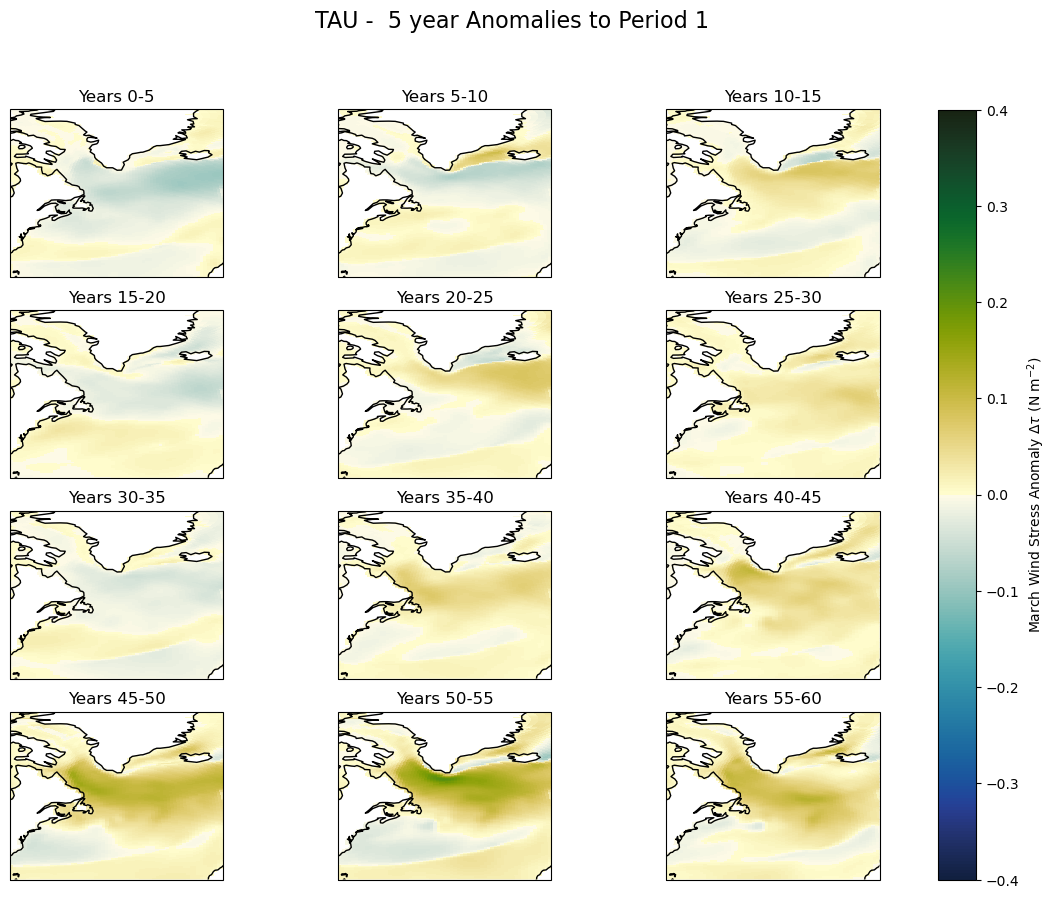

In [53]:
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(15, 10), subplot_kw={'projection': ccrs.PlateCarree()})
for i, ax in enumerate(axes.flatten()):
    pc = da_anom_mag.isel(time=range(i*5, i*5+5)).mean('time').plot.pcolormesh(
                                                 ax=ax,
                                                 transform=ccrs.PlateCarree(),
                                                 x='TLONG',
                                                 y='TLAT',
                                                 cmap=cmo.cm.delta,
                                                 vmin = vmin, vmax = vmax,
                                                 add_colorbar=False) 
    ax.set_extent([-80,-10, 25, 80], crs=ccrs.PlateCarree())
    ax.set_title(f"Years {(i*5)}-{(i*5)+5}")
    ax.coastlines()
    #cs = ax.contour(x, y, da_mag.isel(time=slice(0, 40)).mean('time'), linewidths=0.5, colors='gray',transform=ccrs.PlateCarree())
    #ax.clabel(cs, fmt='%1.0f', inline=True, fontsize=8)
cbar = fig.colorbar(pc, ax=axes, orientation='vertical', label=r'March Wind Stress Anomaly $\Delta \tau$ (N m$^{-2}$)') 
fig.suptitle('TAU -  5 year Anomalies to Period 1', fontsize=16)
plt.show()
#plt.savefig(os.path.expanduser('~/phase1_CONDA/results/')+TAU_5year_anomalies.png', bbox_inches='tight', dpi=300)    